#Kaggle API

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:12<00:00, 85.5MB/s]
100% 1.14G/1.14G [00:12<00:00, 96.1MB/s]


In [3]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 1 Set up

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Define Constants

In [5]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [6]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [8]:
type(train)

keras.preprocessing.image.DirectoryIterator

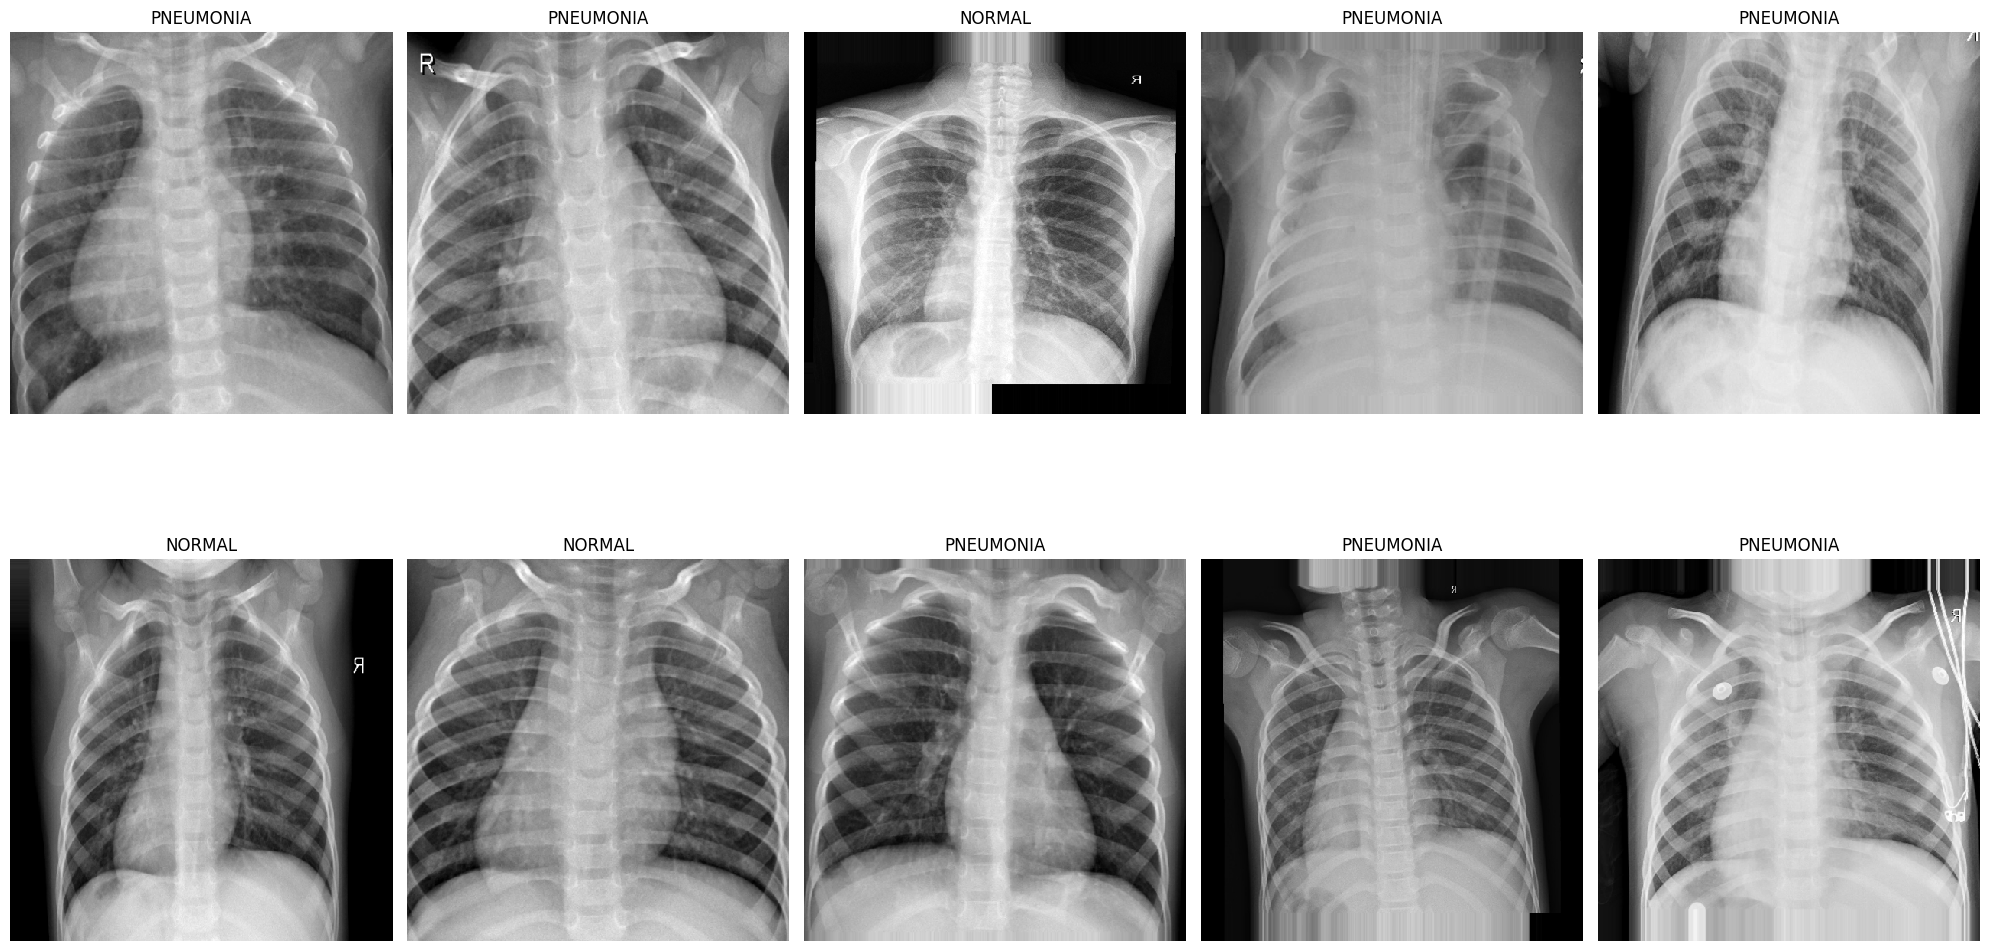

In [9]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [10]:
'''        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening

        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,# randomly flip images
        shear_range=0.2,
        brightness_range=(1.2, 1.5)'''

'        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n\n        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.2, # Randomly zoom image\n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip = True,  # randomly flip images\n        vertical_flip=False,# randomly flip images\n        shear_range=0.2,\n        brightness_range=(1.2, 1.5)'

# 3 Tensorflow - Keras

In [11]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [12]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

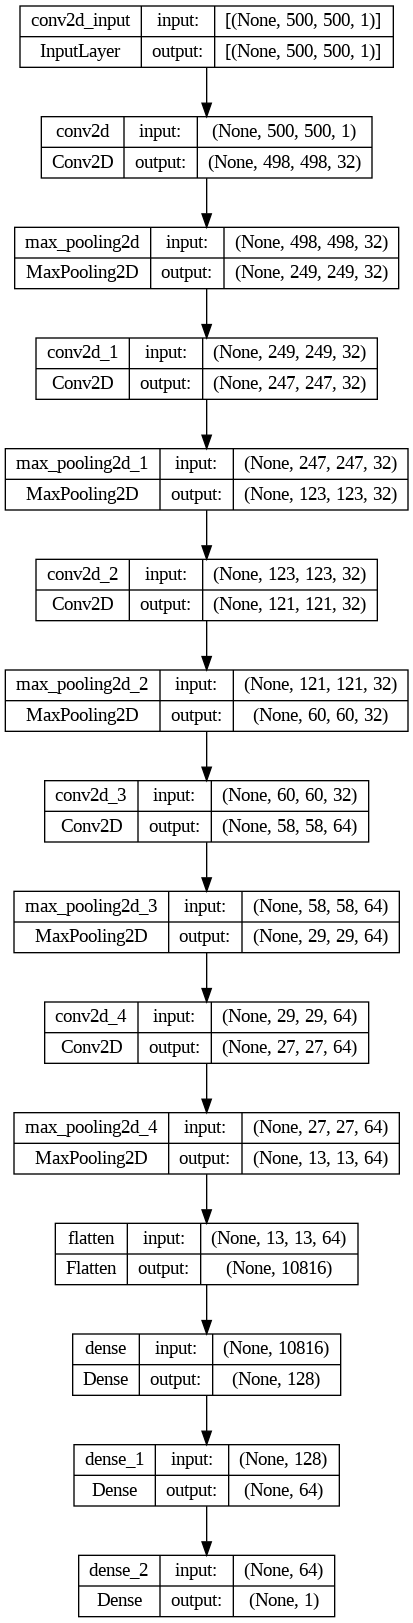

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 3.2 Fit Model

In [15]:
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [16]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [17]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 140s 505ms/step - loss: 0.3840 - accuracy: 0.8189 - val_loss: 0.3346 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 131s 500ms/step - loss: 0.2394 - accuracy: 0.8989 - val_loss: 0.5839 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 138s 528ms/step - loss: 0.2180 - accuracy: 0.9070 - val_loss: 0.1969 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 131s 498ms/step - loss: 0.2098 - accuracy: 0.9108 - val_loss: 0.3241 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9232
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 135s 514ms/step - loss: 0.1806 - accuracy: 0.9232 - val_loss: 0.3173 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 6/25
262/262 [========================

In [18]:
fp = "/content/cnn_pneu_vamp_model.h5"
# cnn.save(fp)

In [19]:
cnn = load_model(fp)

##3.3 Evaluation

In [21]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 11s 241ms/step - loss: 0.3733 - accuracy: 0.8862
The testing accuracy is : 88.62179517745972 %


In [22]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 6s 144ms/step


In [23]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

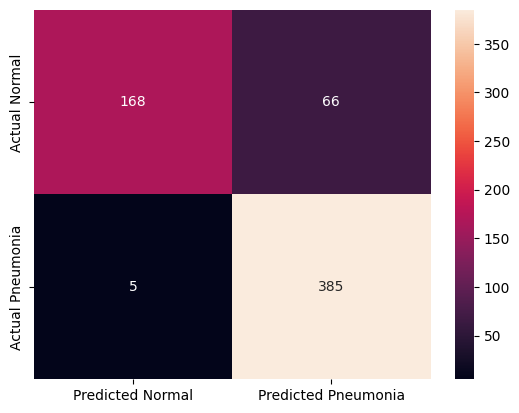

In [24]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [25]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.97      0.72      0.83       234
   PNEUMONIA       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



In [26]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


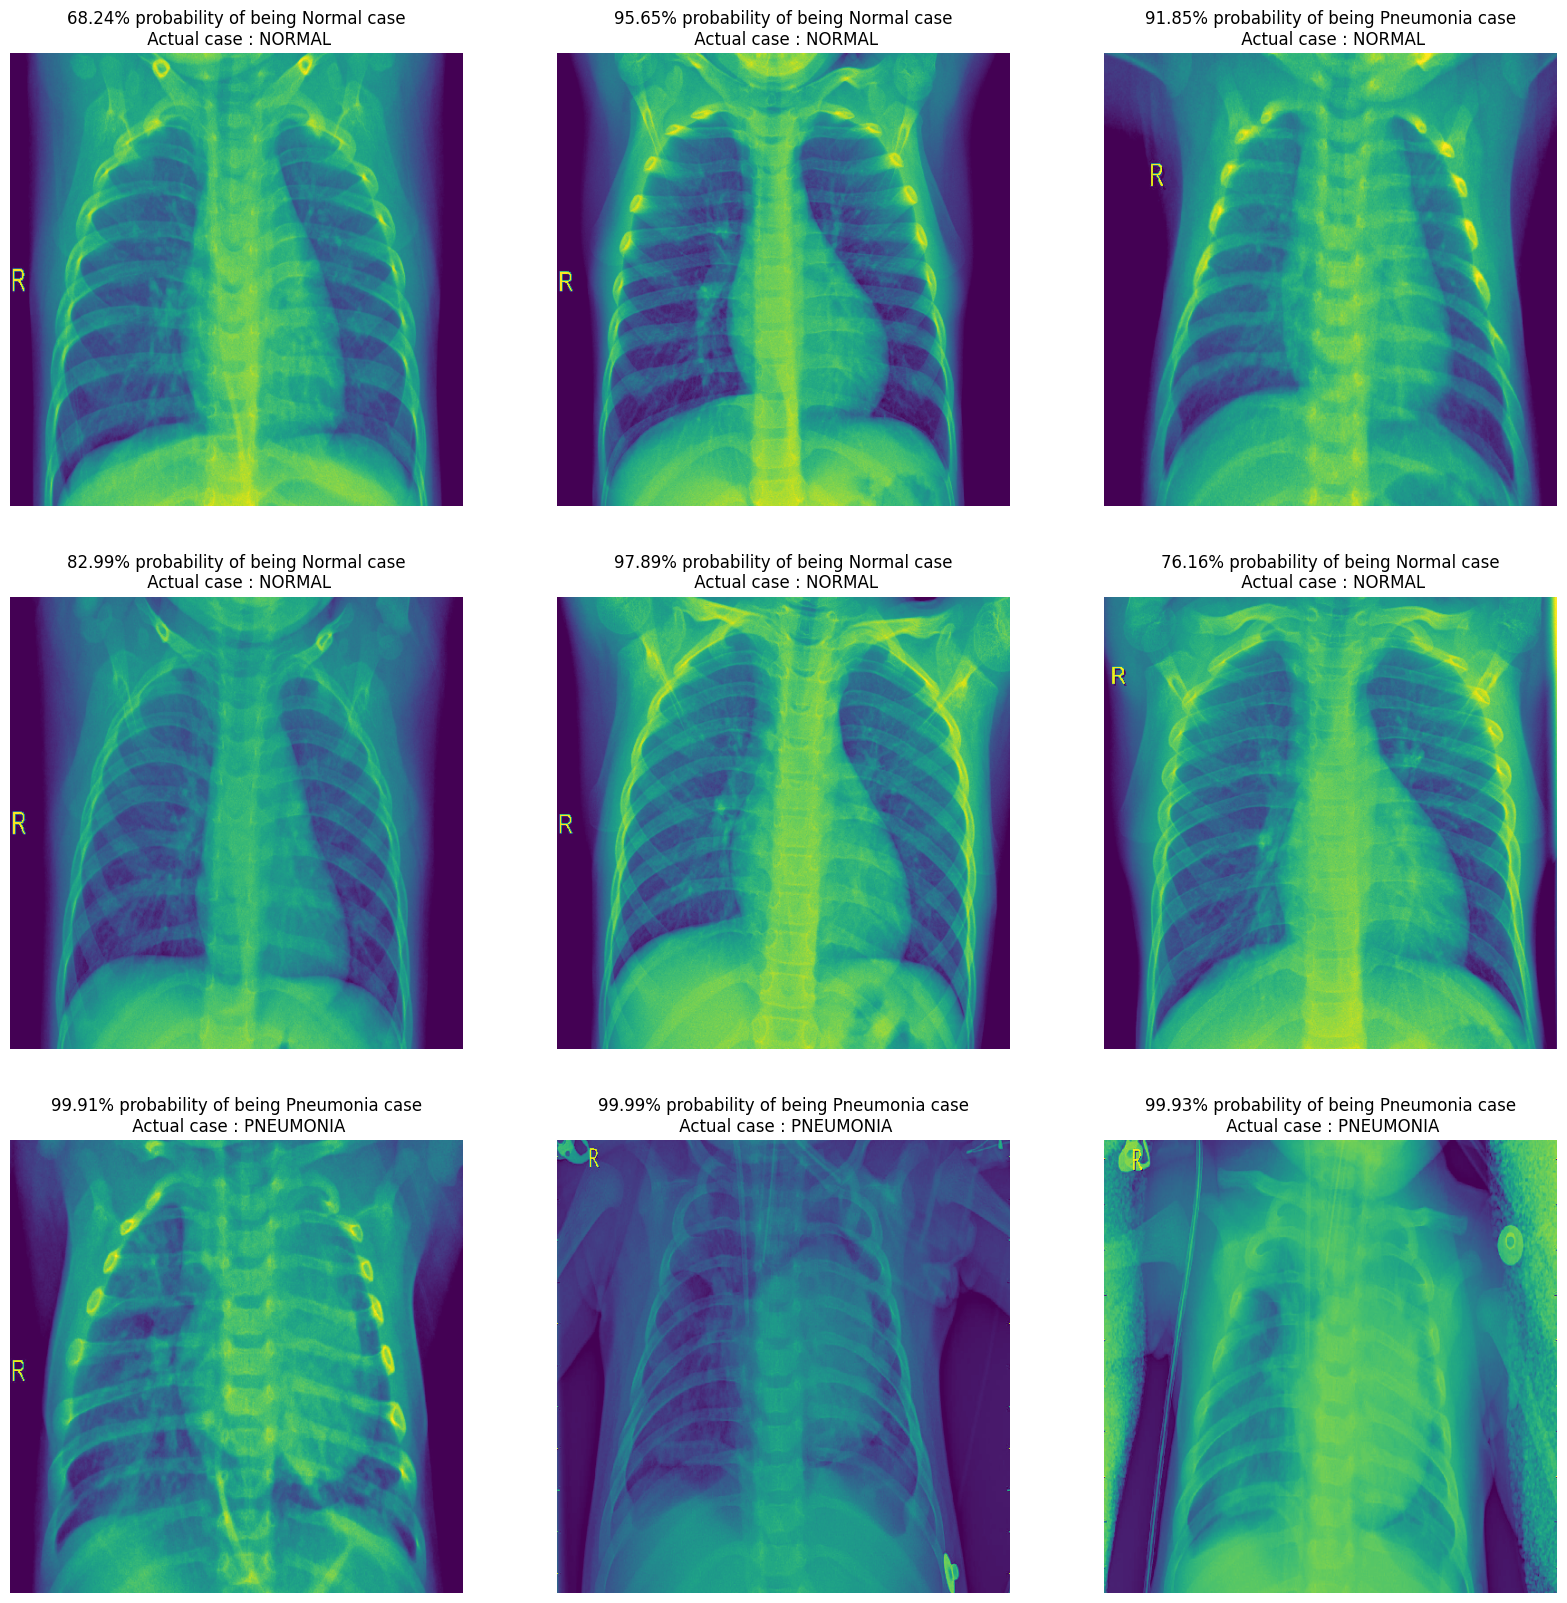

In [27]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [28]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=y ) )\nfig.show()'

In [29]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=predictions[:,0] ) )\nfig.show()'

1/1 [==============================] - 0s 337ms/step


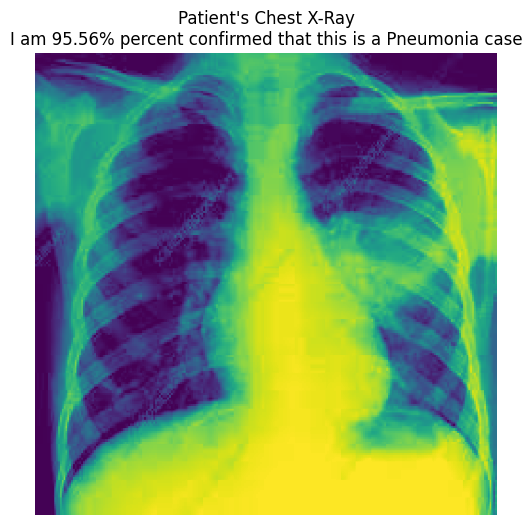

In [32]:
patient_path='/content/test app img.jpg'
from tensorflow.keras.preprocessing import image

patient_img = image.load_img(patient_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_patient_img = image.img_to_array(patient_img)
pp_patient_img = pp_patient_img/255
pp_patient_img = np.expand_dims(pp_patient_img, axis=0)

#predict
patient_preds= cnn.predict(pp_patient_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if patient_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(patient_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-patient_preds[0][0]))


plt.title("Patient's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_patient_img))
plt.show()

# Run streamlit app from a Google Colab Notebook


In [33]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.0 MB/s eta 0:00:00


In [34]:
!pip install h5py

Reset the execution environment after streamlit installation

In [35]:
!wget https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py

--2023-07-23 16:37:07--  https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1607 (1.6K) [text/plain]
Saving to: ‘webapp.py’

webapp.py           100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-07-23 16:37:07 (23.9 MB/s) - ‘webapp.py’ saved [1607/1607]



## OR

## Install ngrok

In [36]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-07-23 16:37:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  41.3MB/s    in 0.3s    

2023-07-23 16:37:13 (41.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [37]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [38]:
%%writefile webapp.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf

from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)

def loading_model():
  fp = "cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()
st.write("""
# X-Ray Classification (Pneumonia/Normal)
""")






temp = st.file_uploader("Upload X-Ray Image")

buffer = temp
temp_file = NamedTemporaryFile(delete=False)
if buffer:
    temp_file.write(buffer.getvalue())
    st.write(image.load_img(temp_file.name))


if buffer is None:
  st.text("Oops! that doesn't look like an image. Try again.")

else:



  patient_img = image.load_img(temp_file.name, target_size=(500, 500),color_mode='grayscale')

  # Preprocessing the image
  pp_patient_img = image.img_to_array(patient_img)
  pp_patient_img = pp_patient_img/255
  pp_patient_img = np.expand_dims(pp_patient_img, axis=0)

  #predict
  patient_preds= cnn.predict(pp_patient_img)
  if patient_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(patient_preds[0][0]))

  else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-patient_preds[0][0]))

  st.success(out)

  image = Image.open(temp)
  st.image(image,use_column_width=True)








Overwriting webapp.py


In [39]:
!pip install pyngrok==2.0.0

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-2.0.0-py3-none-any.whl size=12088 sha256=4cc7b2177e7d5cf41380fbb8450b2a28e812bbff42e22b02b3fdc9bf54e03a7e
  Stored in directory: /root/.cache/pip/wheels/c3/8e/11/5a79884d989de25672232038fc437fd2e5b5f247c01fc436f2
Successfully built pyngrok


In [40]:
!ngrok authtoken 2SiKHsPbuz6DdbtXdSlN8SIjIH0_5uddkGoUKVCHgyBASAV8K

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [41]:
get_ipython().system_raw('./ngrok http 8501 &')

In [42]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://779f-35-225-70-243.ngrok-free.app


In [43]:
!streamlit run /content/webapp.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.225.70.243:8501

2023-07-23 16:38:02.988466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-23 16:38:05.679668: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-23 16:38:06.007 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
2023-07-23 16:38:32.571 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
1/1 [==============================] - 2s 2s/st